In [1]:
import json
from pathlib import Path

import lightning.pytorch as L
import torch
from lightning.pytorch.callbacks import Callback, ModelCheckpoint
from matplotlib import pyplot as plt
from torchmetrics.classification import MulticlassAccuracy
import wandb
import numpy as np

from sainomore.callbacks import (ElissabethISTracker, ElissabethWeighting,
                                 GeneralConfigCallback, WeightHistory)
from sainomore.data import GivenDataModule, copying
from sainomore.elissabeth import Elissabeth, Weighting
from sainomore.lightning import TokenPredictionModule
from sainomore.xai import get_attention_matrices, plot_attention_matrix
from sainomore.xai import ElissabethWatcher

In [2]:
api = wandb.Api()
run = api.run("krieg-team/Elissabeth Copying/s9rruq6n")

In [38]:
def get_metric(name: str) -> np.ndarray:
    return np.array([row[name] for row in run.scan_history(keys=[name])])

In [40]:
get_metric("train/loss")

array([2.29384899, 2.10947227, 2.05497122, ..., 0.0959129 , 0.08900119,
       0.10423453])

In [5]:
config = {
    "n_samples": 500,
    "context_length": 100,
    "n_categories": 5,
    "to_copy": 2,

    "lr": 5e-3,
    "weight_decay": 1e-4,
    "epochs": 1001,

    "batch_size": 64,
    "val_size": 0.2,
}

with open("config.json", "r") as f:
    model_config = json.load(f)

model_config["context_length"] = config["context_length"]
model_config["input_vocab_size"] = config["n_categories"]

model = Elissabeth.build(
    model_config,
    # Weighting.MSC,
    # Weighting.ExponentialDecay,
)

lightning_module = TokenPredictionModule(
    model,
    learning_rate=config["lr"],
    weight_decay=config["weight_decay"],
    loss=torch.nn.CrossEntropyLoss(ignore_index=-1),
    accuracy=MulticlassAccuracy(config["n_categories"], ignore_index=-1),
    only_last=False,
)

In [6]:
watcher = ElissabethWatcher.load("version_31", on_cpu=True)

In [13]:
x, y = copying(
    n_samples=1,
    length=config["context_length"],
    n_categories=config["n_categories"],
    to_copy=config["to_copy"],
)

In [14]:
print(x, "\n", y)

tensor([[1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 4, 3, 3]]) 
 tensor([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1,  1,  0]])


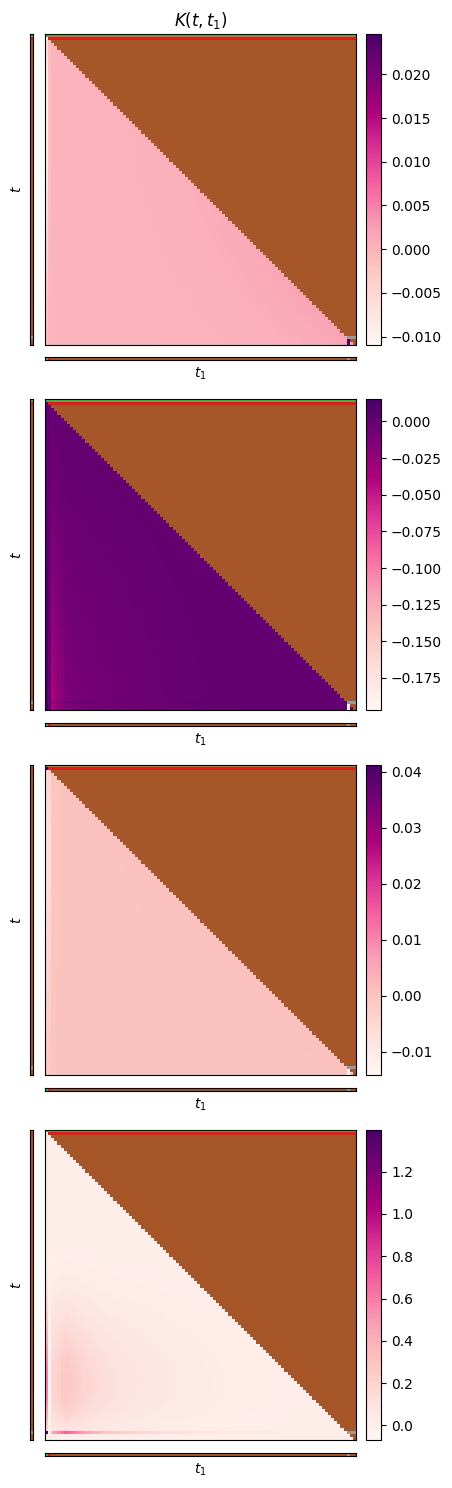

In [16]:
fig, ax = watcher.plot_attention_matrices(
    x[0],
    # total=True,
    cmap="RdPu",
    share_cmap=False,
    log_cmap=False,
    causal_mask=True,
    figsize=(10, 15),
)

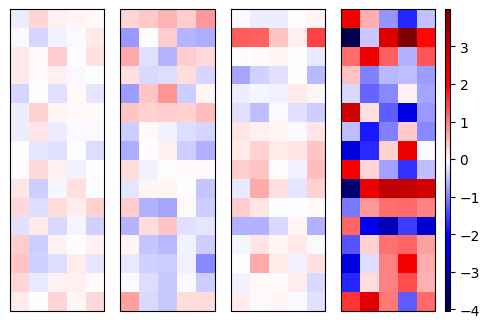

In [19]:
fig, ax = watcher.plot_parameter_matrix(
    "layers.0.W_O",
    reduce_dims={4: 0},
    figsize=(5, 10),
)

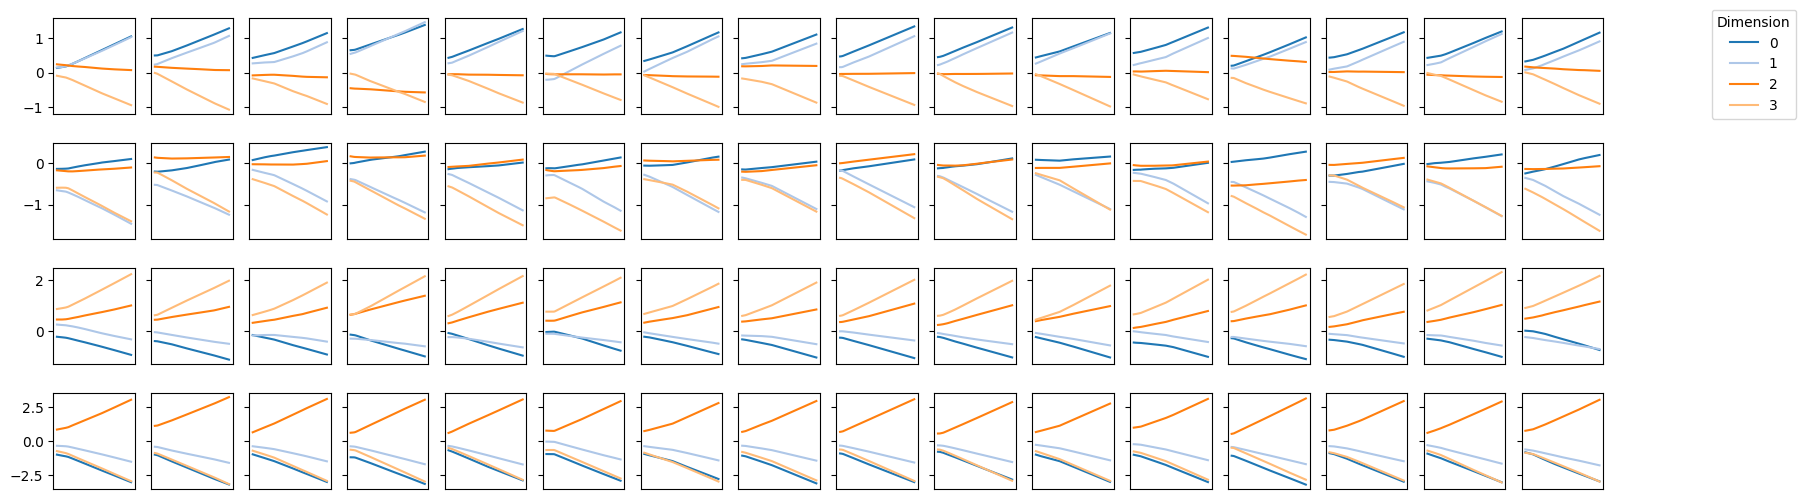

In [29]:
fig, ax = watcher.plot_qkv_probing(
    which="q",
    layer=0,
    length=0,
    weighting=0,
    figsize=(20, 5),
)

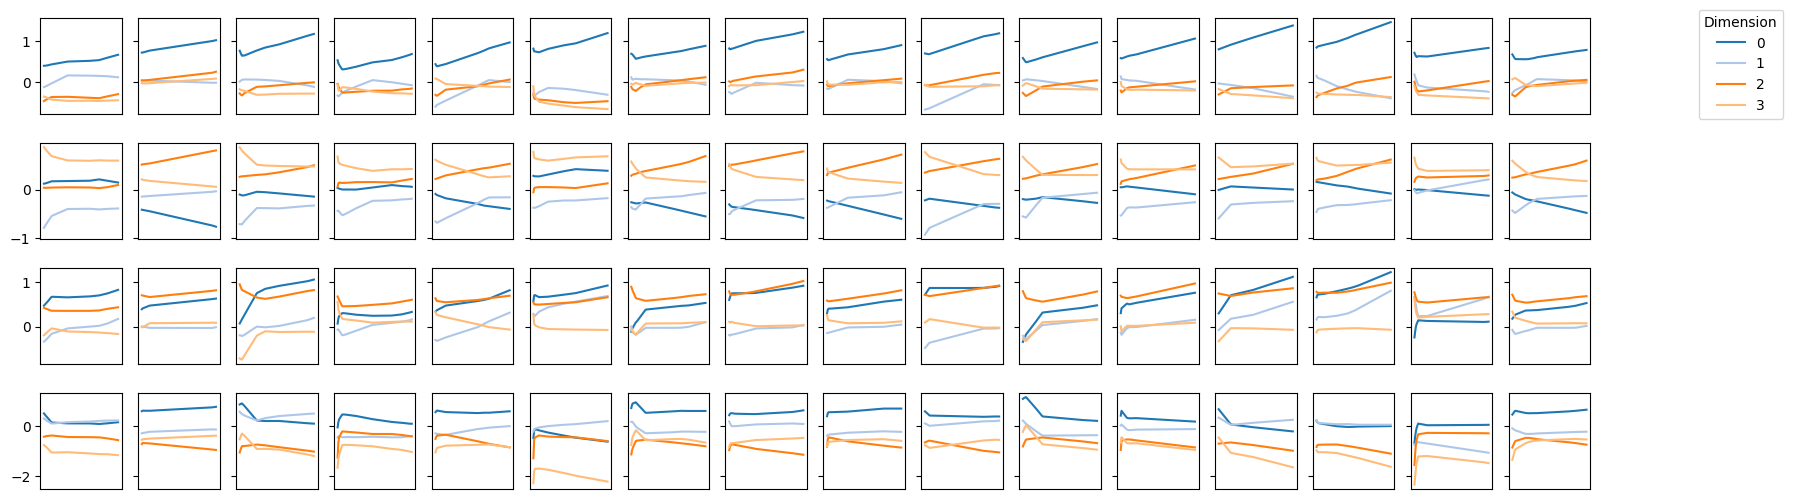

In [30]:
fig, ax = watcher.plot_qkv_probing(
    which="k",
    layer=0,
    length=0,
    weighting=0,
    figsize=(20, 5),
)